In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
if not os.path.exists('data/gan_images'):
    os.makedirs('data/gan_images')

In [3]:
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100, activation=layers.LeakyReLU(0.2)))
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D())  # 가로, 세로 길이가 2배씩 늘어나 총 면적이 4배로 늘어나게 함
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [4]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 판별하는 용도이므로 학습하지 않도록 설정 (Trainable params: 0)
discriminator.trainable = False
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [5]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [6]:
# discriminator 학습
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5  # -1~1 사이 값으로 변환? generator에서 tanh(-1~1)으로 계산된 값을 반환하기 때문
    
    true = np.ones((batch_size, 1))
    false = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)  # discriminator가 진짜를 가지고 학습할 때 생기는 오차
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)  # generator가 생성한 이미지
        d_loss_fake = discriminator.train_on_batch(gen_imgs, false)  # discriminator가 가짜를 가지고 학습할 때 생기는 오차
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        # 서로 경쟁하는 모습이 보임
        print('epoch: %d' % i, 'd_loss: %.4f' % d_loss, 'g_loss: %.4f' % g_loss)
        
        if i % saving_interval == 0:
            #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 124ms/step
epoch: 0 d_loss: 0.7006 g_loss: 0.6277
1/1 [==============================] - 0s 26ms/step
epoch: 1 d_loss: 0.4879 g_loss: 0.3153
1/1 [==============================] - 0s 26ms/step
epoch: 2 d_loss: 0.4473 g_loss: 0.0920
1/1 [==============================] - 0s 28ms/step
epoch: 3 d_loss: 0.5029 g_loss: 0.0323
1/1 [==============================] - 0s 26ms/step
epoch: 4 d_loss: 0.5393 g_loss: 0.0430
1/1 [==============================] - 0s 26ms/step
epoch: 5 d_loss: 0.5233 g_loss: 0.1243
1/1 [==============================] - 0s 27ms/step
epoch: 6 d_loss: 0.4521 g_loss: 0.3460
1/1 [==============================] - 0s 29ms/step
epoch: 7 d_loss: 0.4813 g_loss: 0.4667
1/1 [==============================] - 0s 27ms/step
epoch: 8 d_loss: 0.4956 g_loss: 0.4954
1/1 [==============================] - 0s 26ms/step
epoch: 9 d_loss: 0.4849 g_loss: 0.4748
1/1 [==============================] - 0s 26ms/step
epoch: 10 d_loss: 0.4400 g_loss: 0.50

1/1 [==============================] - 0s 41ms/step
epoch: 89 d_loss: 0.4904 g_loss: 1.3339
1/1 [==============================] - 0s 39ms/step
epoch: 90 d_loss: 0.4204 g_loss: 1.3522
1/1 [==============================] - 0s 39ms/step
epoch: 91 d_loss: 0.4758 g_loss: 1.2926
1/1 [==============================] - 0s 38ms/step
epoch: 92 d_loss: 0.4830 g_loss: 1.2690
1/1 [==============================] - 0s 40ms/step
epoch: 93 d_loss: 0.4689 g_loss: 1.3117
1/1 [==============================] - 0s 39ms/step
epoch: 94 d_loss: 0.5429 g_loss: 1.2426
1/1 [==============================] - 0s 39ms/step
epoch: 95 d_loss: 0.4813 g_loss: 1.4580
1/1 [==============================] - 0s 38ms/step
epoch: 96 d_loss: 0.4995 g_loss: 1.2422
1/1 [==============================] - 0s 45ms/step
epoch: 97 d_loss: 0.4879 g_loss: 1.2534
1/1 [==============================] - 0s 40ms/step
epoch: 98 d_loss: 0.5603 g_loss: 1.3415
1/1 [==============================] - 0s 39ms/step
epoch: 99 d_loss: 0.4873 g_l

1/1 [==============================] - 0s 26ms/step
epoch: 177 d_loss: 0.4896 g_loss: 1.6670
1/1 [==============================] - 0s 26ms/step
epoch: 178 d_loss: 0.4181 g_loss: 1.6728
1/1 [==============================] - 0s 25ms/step
epoch: 179 d_loss: 0.4430 g_loss: 1.9557
1/1 [==============================] - 0s 26ms/step
epoch: 180 d_loss: 0.3377 g_loss: 1.6135
1/1 [==============================] - 0s 24ms/step
epoch: 181 d_loss: 0.4355 g_loss: 1.5495
1/1 [==============================] - 0s 26ms/step
epoch: 182 d_loss: 0.5848 g_loss: 1.8220
1/1 [==============================] - 0s 26ms/step
epoch: 183 d_loss: 0.4377 g_loss: 1.4953
1/1 [==============================] - 0s 22ms/step
epoch: 184 d_loss: 0.3322 g_loss: 1.6129
1/1 [==============================] - 0s 26ms/step
epoch: 185 d_loss: 0.3960 g_loss: 1.3376
1/1 [==============================] - 0s 23ms/step
epoch: 186 d_loss: 0.3987 g_loss: 1.4687
1/1 [==============================] - 0s 22ms/step
epoch: 187 d_loss:

epoch: 264 d_loss: 0.4781 g_loss: 1.9784
1/1 [==============================] - 0s 24ms/step
epoch: 265 d_loss: 0.6527 g_loss: 1.6935
1/1 [==============================] - 0s 25ms/step
epoch: 266 d_loss: 0.5219 g_loss: 1.9999
1/1 [==============================] - 0s 26ms/step
epoch: 267 d_loss: 0.4982 g_loss: 1.9191
1/1 [==============================] - 0s 26ms/step
epoch: 268 d_loss: 0.7703 g_loss: 1.5386
1/1 [==============================] - 0s 22ms/step
epoch: 269 d_loss: 0.4797 g_loss: 1.9054
1/1 [==============================] - 0s 26ms/step
epoch: 270 d_loss: 0.4153 g_loss: 1.7414
1/1 [==============================] - 0s 26ms/step
epoch: 271 d_loss: 0.6011 g_loss: 1.6692
1/1 [==============================] - 0s 22ms/step
epoch: 272 d_loss: 0.6450 g_loss: 1.8323
1/1 [==============================] - 0s 26ms/step
epoch: 273 d_loss: 0.6188 g_loss: 1.8714
1/1 [==============================] - 0s 26ms/step
epoch: 274 d_loss: 0.5311 g_loss: 1.9175
1/1 [========================

epoch: 352 d_loss: 0.3945 g_loss: 1.8439
1/1 [==============================] - 0s 25ms/step
epoch: 353 d_loss: 0.5309 g_loss: 1.9824
1/1 [==============================] - 0s 24ms/step
epoch: 354 d_loss: 0.4364 g_loss: 1.7613
1/1 [==============================] - 0s 22ms/step
epoch: 355 d_loss: 0.4716 g_loss: 1.7388
1/1 [==============================] - 0s 38ms/step
epoch: 356 d_loss: 0.4420 g_loss: 1.6249
1/1 [==============================] - 0s 48ms/step
epoch: 357 d_loss: 0.3723 g_loss: 2.0195
1/1 [==============================] - 0s 39ms/step
epoch: 358 d_loss: 0.3947 g_loss: 1.6491
1/1 [==============================] - 0s 38ms/step
epoch: 359 d_loss: 0.6556 g_loss: 1.7096
1/1 [==============================] - 0s 38ms/step
epoch: 360 d_loss: 0.4744 g_loss: 1.9932
1/1 [==============================] - 0s 25ms/step
epoch: 361 d_loss: 0.3967 g_loss: 1.9171
1/1 [==============================] - 0s 24ms/step
epoch: 362 d_loss: 0.5867 g_loss: 1.8217
1/1 [========================

1/1 [==============================] - 0s 25ms/step
epoch: 440 d_loss: 0.2287 g_loss: 2.5130
1/1 [==============================] - 0s 25ms/step
epoch: 441 d_loss: 0.2067 g_loss: 2.4877
1/1 [==============================] - 0s 25ms/step
epoch: 442 d_loss: 0.2724 g_loss: 2.4898
1/1 [==============================] - 0s 25ms/step
epoch: 443 d_loss: 0.2152 g_loss: 2.6493
1/1 [==============================] - 0s 22ms/step
epoch: 444 d_loss: 0.2216 g_loss: 2.3931
1/1 [==============================] - 0s 27ms/step
epoch: 445 d_loss: 0.2475 g_loss: 2.1151
1/1 [==============================] - 0s 25ms/step
epoch: 446 d_loss: 0.2203 g_loss: 2.6660
1/1 [==============================] - 0s 24ms/step
epoch: 447 d_loss: 0.2174 g_loss: 3.0867
1/1 [==============================] - 0s 25ms/step
epoch: 448 d_loss: 0.2154 g_loss: 3.0310
1/1 [==============================] - 0s 24ms/step
epoch: 449 d_loss: 0.2324 g_loss: 2.9915
1/1 [==============================] - 0s 25ms/step
epoch: 450 d_loss:

1/1 [==============================] - 0s 26ms/step
epoch: 528 d_loss: 0.1984 g_loss: 2.0979
1/1 [==============================] - 0s 33ms/step
epoch: 529 d_loss: 0.3581 g_loss: 2.0140
1/1 [==============================] - 0s 56ms/step
epoch: 530 d_loss: 0.2017 g_loss: 2.4245
1/1 [==============================] - 0s 37ms/step
epoch: 531 d_loss: 0.2320 g_loss: 2.9688
1/1 [==============================] - 0s 39ms/step
epoch: 532 d_loss: 0.3358 g_loss: 2.7450
1/1 [==============================] - 0s 39ms/step
epoch: 533 d_loss: 0.2852 g_loss: 2.5185
1/1 [==============================] - 0s 40ms/step
epoch: 534 d_loss: 0.2428 g_loss: 2.3833
1/1 [==============================] - 0s 38ms/step
epoch: 535 d_loss: 0.3521 g_loss: 2.1962
1/1 [==============================] - 0s 40ms/step
epoch: 536 d_loss: 0.2837 g_loss: 2.3468
1/1 [==============================] - 0s 55ms/step
epoch: 537 d_loss: 0.1952 g_loss: 2.5825
1/1 [==============================] - 0s 41ms/step
epoch: 538 d_loss:

epoch: 615 d_loss: 0.3674 g_loss: 2.0716
1/1 [==============================] - 0s 27ms/step
epoch: 616 d_loss: 0.2394 g_loss: 2.1527
1/1 [==============================] - 0s 26ms/step
epoch: 617 d_loss: 0.3097 g_loss: 2.5332
1/1 [==============================] - 0s 26ms/step
epoch: 618 d_loss: 0.1977 g_loss: 3.0717
1/1 [==============================] - 0s 25ms/step
epoch: 619 d_loss: 0.2341 g_loss: 3.1232
1/1 [==============================] - 0s 24ms/step
epoch: 620 d_loss: 0.5909 g_loss: 2.6152
1/1 [==============================] - 0s 24ms/step
epoch: 621 d_loss: 0.2424 g_loss: 1.9458
1/1 [==============================] - 0s 26ms/step
epoch: 622 d_loss: 0.3254 g_loss: 1.5406
1/1 [==============================] - 0s 25ms/step
epoch: 623 d_loss: 0.4725 g_loss: 1.7477
1/1 [==============================] - 0s 24ms/step
epoch: 624 d_loss: 0.2260 g_loss: 2.3792
1/1 [==============================] - 0s 24ms/step
epoch: 625 d_loss: 0.3004 g_loss: 2.6933
1/1 [========================

1/1 [==============================] - 0s 24ms/step
epoch: 704 d_loss: 0.5904 g_loss: 1.1196
1/1 [==============================] - 0s 25ms/step
epoch: 705 d_loss: 0.5736 g_loss: 1.2735
1/1 [==============================] - 0s 21ms/step
epoch: 706 d_loss: 0.6530 g_loss: 1.3583
1/1 [==============================] - 0s 25ms/step
epoch: 707 d_loss: 0.7977 g_loss: 1.3684
1/1 [==============================] - 0s 26ms/step
epoch: 708 d_loss: 0.8046 g_loss: 1.0857
1/1 [==============================] - 0s 25ms/step
epoch: 709 d_loss: 0.6858 g_loss: 1.0627
1/1 [==============================] - 0s 25ms/step
epoch: 710 d_loss: 0.6831 g_loss: 0.8027
1/1 [==============================] - 0s 26ms/step
epoch: 711 d_loss: 0.7199 g_loss: 0.9482
1/1 [==============================] - 0s 22ms/step
epoch: 712 d_loss: 0.8061 g_loss: 1.1543
1/1 [==============================] - 0s 24ms/step
epoch: 713 d_loss: 0.6504 g_loss: 1.5141
1/1 [==============================] - 0s 25ms/step
epoch: 714 d_loss:

1/1 [==============================] - 0s 21ms/step
epoch: 792 d_loss: 0.4280 g_loss: 1.8683
1/1 [==============================] - 0s 25ms/step
epoch: 793 d_loss: 0.4374 g_loss: 1.6724
1/1 [==============================] - 0s 22ms/step
epoch: 794 d_loss: 0.3272 g_loss: 1.9038
1/1 [==============================] - 0s 23ms/step
epoch: 795 d_loss: 0.4534 g_loss: 1.9459
1/1 [==============================] - 0s 25ms/step
epoch: 796 d_loss: 0.3190 g_loss: 1.7827
1/1 [==============================] - 0s 26ms/step
epoch: 797 d_loss: 0.3073 g_loss: 2.3558
1/1 [==============================] - 0s 26ms/step
epoch: 798 d_loss: 0.3637 g_loss: 2.0694
1/1 [==============================] - 0s 25ms/step
epoch: 799 d_loss: 0.4087 g_loss: 2.0828
1/1 [==============================] - 0s 22ms/step
epoch: 800 d_loss: 0.3290 g_loss: 2.1265
1/1 [==============================] - 0s 25ms/step
epoch: 801 d_loss: 0.4330 g_loss: 1.6399
1/1 [==============================] - 0s 25ms/step
epoch: 802 d_loss:

epoch: 879 d_loss: 0.4061 g_loss: 1.8899
1/1 [==============================] - 0s 26ms/step
epoch: 880 d_loss: 0.3601 g_loss: 1.8569
1/1 [==============================] - 0s 25ms/step
epoch: 881 d_loss: 0.3240 g_loss: 1.9881
1/1 [==============================] - 0s 26ms/step
epoch: 882 d_loss: 0.2477 g_loss: 2.1214
1/1 [==============================] - 0s 24ms/step
epoch: 883 d_loss: 0.3735 g_loss: 1.9754
1/1 [==============================] - 0s 25ms/step
epoch: 884 d_loss: 0.4150 g_loss: 2.0597
1/1 [==============================] - 0s 24ms/step
epoch: 885 d_loss: 0.2847 g_loss: 2.1807
1/1 [==============================] - 0s 24ms/step
epoch: 886 d_loss: 0.3859 g_loss: 2.3364
1/1 [==============================] - 0s 23ms/step
epoch: 887 d_loss: 0.3923 g_loss: 2.4029
1/1 [==============================] - 0s 25ms/step
epoch: 888 d_loss: 0.3362 g_loss: 2.2411
1/1 [==============================] - 0s 19ms/step
epoch: 889 d_loss: 0.3261 g_loss: 1.8779
1/1 [========================

1/1 [==============================] - 0s 27ms/step
epoch: 968 d_loss: 0.3262 g_loss: 2.0486
1/1 [==============================] - 0s 25ms/step
epoch: 969 d_loss: 0.4924 g_loss: 1.9183
1/1 [==============================] - 0s 22ms/step
epoch: 970 d_loss: 0.5055 g_loss: 1.8050
1/1 [==============================] - 0s 24ms/step
epoch: 971 d_loss: 0.2866 g_loss: 2.5681
1/1 [==============================] - 0s 26ms/step
epoch: 972 d_loss: 0.3086 g_loss: 2.3251
1/1 [==============================] - 0s 25ms/step
epoch: 973 d_loss: 0.2589 g_loss: 3.2679
1/1 [==============================] - 0s 24ms/step
epoch: 974 d_loss: 0.5092 g_loss: 2.1778
1/1 [==============================] - 0s 27ms/step
epoch: 975 d_loss: 0.3070 g_loss: 2.5807
1/1 [==============================] - 0s 25ms/step
epoch: 976 d_loss: 0.2588 g_loss: 2.3588
1/1 [==============================] - 0s 26ms/step
epoch: 977 d_loss: 0.3365 g_loss: 2.2165
1/1 [==============================] - 0s 26ms/step
epoch: 978 d_loss:

1/1 [==============================] - 0s 26ms/step
epoch: 1055 d_loss: 0.3211 g_loss: 1.9561
1/1 [==============================] - 0s 27ms/step
epoch: 1056 d_loss: 0.4607 g_loss: 2.5862
1/1 [==============================] - 0s 25ms/step
epoch: 1057 d_loss: 0.4502 g_loss: 2.8171
1/1 [==============================] - 0s 26ms/step
epoch: 1058 d_loss: 0.4045 g_loss: 2.0063
1/1 [==============================] - 0s 22ms/step
epoch: 1059 d_loss: 0.3105 g_loss: 1.6925
1/1 [==============================] - 0s 24ms/step
epoch: 1060 d_loss: 0.2974 g_loss: 2.5197
1/1 [==============================] - 0s 24ms/step
epoch: 1061 d_loss: 0.3363 g_loss: 2.6776
1/1 [==============================] - 0s 25ms/step
epoch: 1062 d_loss: 0.3268 g_loss: 2.9830
1/1 [==============================] - 0s 25ms/step
epoch: 1063 d_loss: 0.3881 g_loss: 2.2393
1/1 [==============================] - 0s 25ms/step
epoch: 1064 d_loss: 0.3209 g_loss: 1.9503
1/1 [==============================] - 0s 24ms/step
epoch: 1

1/1 [==============================] - 0s 40ms/step
epoch: 1142 d_loss: 0.1990 g_loss: 2.3004
1/1 [==============================] - 0s 39ms/step
epoch: 1143 d_loss: 0.2501 g_loss: 2.2724
1/1 [==============================] - 0s 39ms/step
epoch: 1144 d_loss: 0.2386 g_loss: 2.7736
1/1 [==============================] - 0s 38ms/step
epoch: 1145 d_loss: 0.3498 g_loss: 1.9921
1/1 [==============================] - 0s 39ms/step
epoch: 1146 d_loss: 0.4038 g_loss: 2.4792
1/1 [==============================] - 0s 38ms/step
epoch: 1147 d_loss: 0.3424 g_loss: 2.3888
1/1 [==============================] - 0s 39ms/step
epoch: 1148 d_loss: 0.3205 g_loss: 2.1789
1/1 [==============================] - 0s 38ms/step
epoch: 1149 d_loss: 0.4001 g_loss: 2.2231
1/1 [==============================] - 0s 39ms/step
epoch: 1150 d_loss: 0.3253 g_loss: 2.4373
1/1 [==============================] - 0s 39ms/step
epoch: 1151 d_loss: 0.5090 g_loss: 2.0600
1/1 [==============================] - 0s 38ms/step
epoch: 1

1/1 [==============================] - 0s 27ms/step
epoch: 1229 d_loss: 0.4340 g_loss: 2.1161
1/1 [==============================] - 0s 23ms/step
epoch: 1230 d_loss: 0.4213 g_loss: 2.8409
1/1 [==============================] - 0s 27ms/step
epoch: 1231 d_loss: 0.3248 g_loss: 2.8571
1/1 [==============================] - 0s 25ms/step
epoch: 1232 d_loss: 0.4316 g_loss: 2.5104
1/1 [==============================] - 0s 25ms/step
epoch: 1233 d_loss: 0.2458 g_loss: 2.7764
1/1 [==============================] - 0s 23ms/step
epoch: 1234 d_loss: 0.2793 g_loss: 3.2379
1/1 [==============================] - 0s 26ms/step
epoch: 1235 d_loss: 0.3835 g_loss: 2.9892
1/1 [==============================] - 0s 25ms/step
epoch: 1236 d_loss: 0.3695 g_loss: 3.0155
1/1 [==============================] - 0s 23ms/step
epoch: 1237 d_loss: 0.2201 g_loss: 2.9092
1/1 [==============================] - 0s 23ms/step
epoch: 1238 d_loss: 0.4545 g_loss: 2.5678
1/1 [==============================] - 0s 22ms/step
epoch: 1

1/1 [==============================] - 0s 25ms/step
epoch: 1316 d_loss: 0.2942 g_loss: 3.0641
1/1 [==============================] - 0s 25ms/step
epoch: 1317 d_loss: 0.4245 g_loss: 2.5474
1/1 [==============================] - 0s 24ms/step
epoch: 1318 d_loss: 0.2109 g_loss: 2.7053
1/1 [==============================] - 0s 22ms/step
epoch: 1319 d_loss: 0.2861 g_loss: 2.8600
1/1 [==============================] - 0s 25ms/step
epoch: 1320 d_loss: 0.2426 g_loss: 3.3253
1/1 [==============================] - 0s 21ms/step
epoch: 1321 d_loss: 0.2456 g_loss: 2.7813
1/1 [==============================] - 0s 22ms/step
epoch: 1322 d_loss: 0.2590 g_loss: 2.6550
1/1 [==============================] - 0s 23ms/step
epoch: 1323 d_loss: 0.2149 g_loss: 2.5328
1/1 [==============================] - 0s 26ms/step
epoch: 1324 d_loss: 0.5169 g_loss: 2.1476
1/1 [==============================] - 0s 26ms/step
epoch: 1325 d_loss: 0.2907 g_loss: 2.6230
1/1 [==============================] - 0s 26ms/step
epoch: 1

1/1 [==============================] - 0s 25ms/step
epoch: 1403 d_loss: 0.5388 g_loss: 1.9186
1/1 [==============================] - 0s 27ms/step
epoch: 1404 d_loss: 0.3439 g_loss: 1.7983
1/1 [==============================] - 0s 24ms/step
epoch: 1405 d_loss: 0.4442 g_loss: 2.2958
1/1 [==============================] - 0s 27ms/step
epoch: 1406 d_loss: 0.5182 g_loss: 2.7380
1/1 [==============================] - 0s 28ms/step
epoch: 1407 d_loss: 0.2908 g_loss: 2.8336
1/1 [==============================] - 0s 25ms/step
epoch: 1408 d_loss: 0.4604 g_loss: 2.8845
1/1 [==============================] - 0s 26ms/step
epoch: 1409 d_loss: 0.4270 g_loss: 2.1749
1/1 [==============================] - 0s 26ms/step
epoch: 1410 d_loss: 0.4598 g_loss: 1.8665
1/1 [==============================] - 0s 26ms/step
epoch: 1411 d_loss: 0.5544 g_loss: 1.5884
1/1 [==============================] - 0s 26ms/step
epoch: 1412 d_loss: 0.6048 g_loss: 1.9029
1/1 [==============================] - 0s 27ms/step
epoch: 1

1/1 [==============================] - 0s 27ms/step
epoch: 1490 d_loss: 0.4962 g_loss: 1.7894
1/1 [==============================] - 0s 26ms/step
epoch: 1491 d_loss: 0.3768 g_loss: 1.7356
1/1 [==============================] - 0s 25ms/step
epoch: 1492 d_loss: 0.4991 g_loss: 1.9262
1/1 [==============================] - 0s 26ms/step
epoch: 1493 d_loss: 0.4732 g_loss: 2.0638
1/1 [==============================] - 0s 25ms/step
epoch: 1494 d_loss: 0.3443 g_loss: 2.2000
1/1 [==============================] - 0s 26ms/step
epoch: 1495 d_loss: 0.5234 g_loss: 1.9725
1/1 [==============================] - 0s 26ms/step
epoch: 1496 d_loss: 0.4747 g_loss: 1.7640
1/1 [==============================] - 0s 26ms/step
epoch: 1497 d_loss: 0.5357 g_loss: 1.8172
1/1 [==============================] - 0s 26ms/step
epoch: 1498 d_loss: 0.4618 g_loss: 1.5936
1/1 [==============================] - 0s 26ms/step
epoch: 1499 d_loss: 0.4814 g_loss: 1.8282
1/1 [==============================] - 0s 26ms/step
epoch: 1

1/1 [==============================] - 0s 23ms/step
epoch: 1577 d_loss: 0.7037 g_loss: 1.4664
1/1 [==============================] - 0s 24ms/step
epoch: 1578 d_loss: 0.3963 g_loss: 2.0259
1/1 [==============================] - 0s 22ms/step
epoch: 1579 d_loss: 0.3836 g_loss: 2.0934
1/1 [==============================] - 0s 26ms/step
epoch: 1580 d_loss: 0.3636 g_loss: 2.3845
1/1 [==============================] - 0s 26ms/step
epoch: 1581 d_loss: 0.4336 g_loss: 2.0868
1/1 [==============================] - 0s 26ms/step
epoch: 1582 d_loss: 0.5735 g_loss: 2.2241
1/1 [==============================] - 0s 25ms/step
epoch: 1583 d_loss: 0.4402 g_loss: 2.2277
1/1 [==============================] - 0s 23ms/step
epoch: 1584 d_loss: 0.5013 g_loss: 1.8479
1/1 [==============================] - 0s 23ms/step
epoch: 1585 d_loss: 0.3482 g_loss: 1.8240
1/1 [==============================] - 0s 25ms/step
epoch: 1586 d_loss: 0.4666 g_loss: 2.0881
1/1 [==============================] - 0s 25ms/step
epoch: 1

epoch: 1663 d_loss: 0.4556 g_loss: 2.1636
1/1 [==============================] - 0s 26ms/step
epoch: 1664 d_loss: 0.6076 g_loss: 1.6961
1/1 [==============================] - 0s 27ms/step
epoch: 1665 d_loss: 0.5313 g_loss: 1.8877
1/1 [==============================] - 0s 26ms/step
epoch: 1666 d_loss: 0.5946 g_loss: 1.4513
1/1 [==============================] - 0s 27ms/step
epoch: 1667 d_loss: 0.5787 g_loss: 1.3401
1/1 [==============================] - 0s 25ms/step
epoch: 1668 d_loss: 0.7031 g_loss: 1.5373
1/1 [==============================] - 0s 26ms/step
epoch: 1669 d_loss: 0.3277 g_loss: 1.9040
1/1 [==============================] - 0s 27ms/step
epoch: 1670 d_loss: 0.4818 g_loss: 1.4728
1/1 [==============================] - 0s 26ms/step
epoch: 1671 d_loss: 0.5264 g_loss: 1.7648
1/1 [==============================] - 0s 25ms/step
epoch: 1672 d_loss: 0.3957 g_loss: 1.7225
1/1 [==============================] - 0s 27ms/step
epoch: 1673 d_loss: 0.5197 g_loss: 1.9400
1/1 [=============

1/1 [==============================] - 0s 25ms/step
epoch: 1751 d_loss: 0.4408 g_loss: 1.4996
1/1 [==============================] - 0s 25ms/step
epoch: 1752 d_loss: 0.4280 g_loss: 1.6284
1/1 [==============================] - 0s 26ms/step
epoch: 1753 d_loss: 0.4710 g_loss: 1.6721
1/1 [==============================] - 0s 23ms/step
epoch: 1754 d_loss: 0.5186 g_loss: 1.9626
1/1 [==============================] - 0s 25ms/step
epoch: 1755 d_loss: 0.4612 g_loss: 1.8511
1/1 [==============================] - 0s 25ms/step
epoch: 1756 d_loss: 0.4908 g_loss: 1.7228
1/1 [==============================] - 0s 26ms/step
epoch: 1757 d_loss: 0.4125 g_loss: 1.7025
1/1 [==============================] - 0s 25ms/step
epoch: 1758 d_loss: 0.4565 g_loss: 1.6495
1/1 [==============================] - 0s 27ms/step
epoch: 1759 d_loss: 0.4539 g_loss: 1.6396
1/1 [==============================] - 0s 25ms/step
epoch: 1760 d_loss: 0.3794 g_loss: 1.5812
1/1 [==============================] - 0s 25ms/step
epoch: 1

1/1 [==============================] - 0s 23ms/step
epoch: 1838 d_loss: 0.4522 g_loss: 1.4372
1/1 [==============================] - 0s 24ms/step
epoch: 1839 d_loss: 0.4089 g_loss: 1.7489
1/1 [==============================] - 0s 29ms/step
epoch: 1840 d_loss: 0.4816 g_loss: 1.4866
1/1 [==============================] - 0s 26ms/step
epoch: 1841 d_loss: 0.6687 g_loss: 1.5420
1/1 [==============================] - 0s 27ms/step
epoch: 1842 d_loss: 0.4730 g_loss: 1.5572
1/1 [==============================] - 0s 26ms/step
epoch: 1843 d_loss: 0.4744 g_loss: 1.4157
1/1 [==============================] - 0s 26ms/step
epoch: 1844 d_loss: 0.5209 g_loss: 1.3804
1/1 [==============================] - 0s 27ms/step
epoch: 1845 d_loss: 0.5666 g_loss: 1.2328
1/1 [==============================] - 0s 26ms/step
epoch: 1846 d_loss: 0.4816 g_loss: 1.4651
1/1 [==============================] - 0s 25ms/step
epoch: 1847 d_loss: 0.5354 g_loss: 1.4495
1/1 [==============================] - 0s 25ms/step
epoch: 1

1/1 [==============================] - 0s 26ms/step
epoch: 1925 d_loss: 0.5679 g_loss: 1.5817
1/1 [==============================] - 0s 25ms/step
epoch: 1926 d_loss: 0.5158 g_loss: 1.5692
1/1 [==============================] - 0s 24ms/step
epoch: 1927 d_loss: 0.6749 g_loss: 1.3016
1/1 [==============================] - 0s 26ms/step
epoch: 1928 d_loss: 0.6148 g_loss: 1.2953
1/1 [==============================] - 0s 23ms/step
epoch: 1929 d_loss: 0.5206 g_loss: 1.4416
1/1 [==============================] - 0s 23ms/step
epoch: 1930 d_loss: 0.5217 g_loss: 1.6540
1/1 [==============================] - 0s 26ms/step
epoch: 1931 d_loss: 0.4181 g_loss: 1.4362
1/1 [==============================] - 0s 25ms/step
epoch: 1932 d_loss: 0.4936 g_loss: 1.5553
1/1 [==============================] - 0s 25ms/step
epoch: 1933 d_loss: 0.5038 g_loss: 1.5058
1/1 [==============================] - 0s 25ms/step
epoch: 1934 d_loss: 0.3770 g_loss: 1.8422
1/1 [==============================] - 0s 25ms/step
epoch: 1

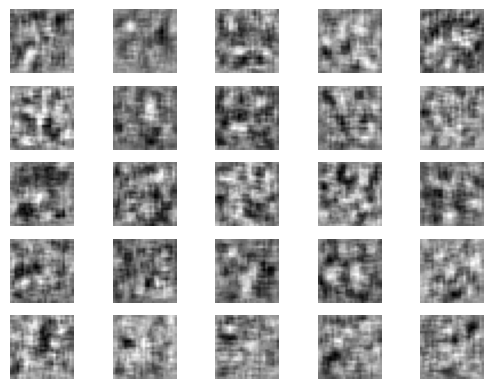

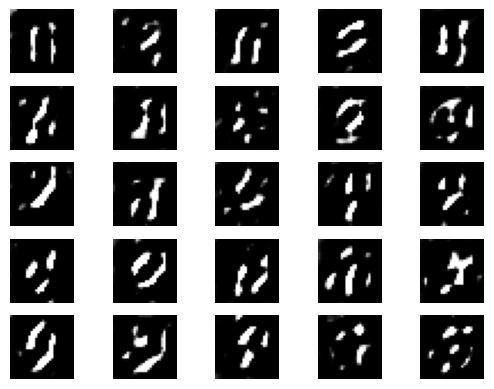

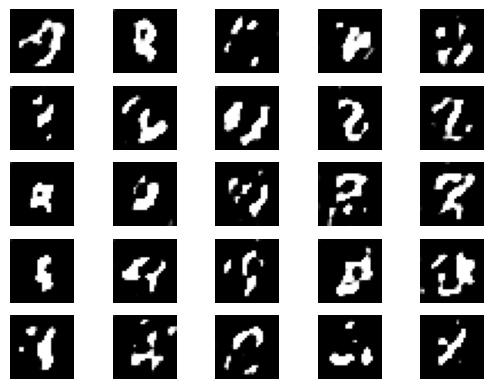

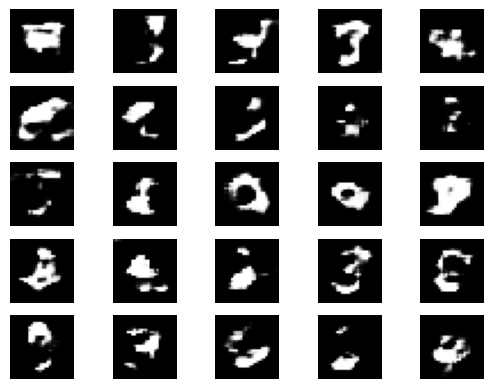

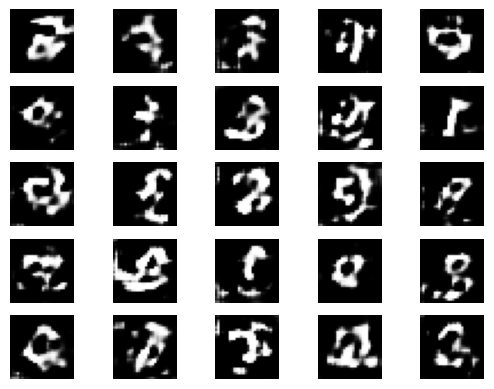

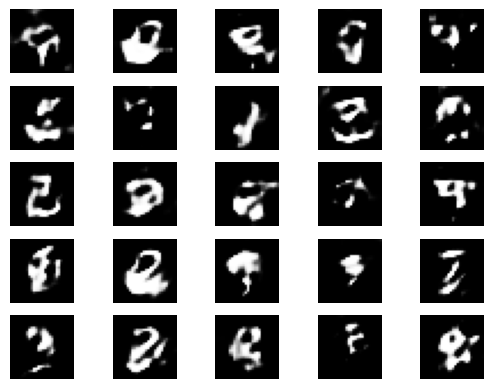

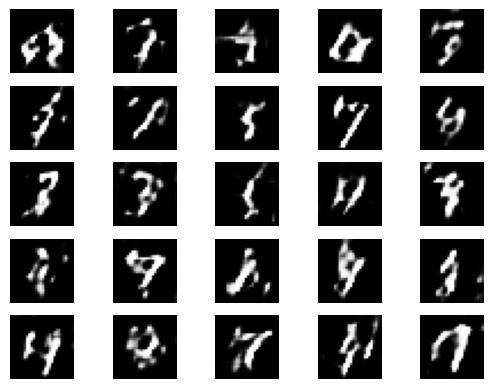

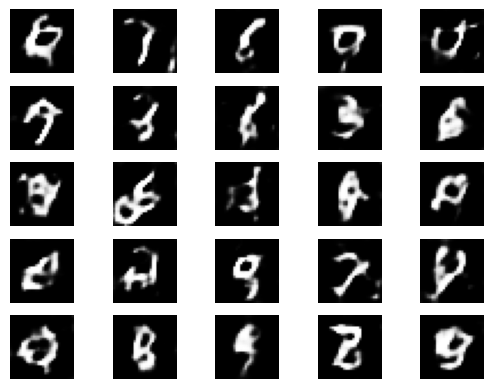

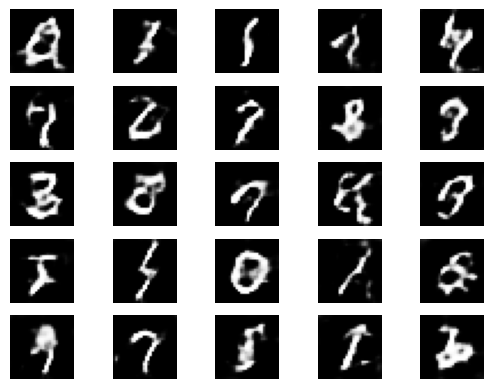

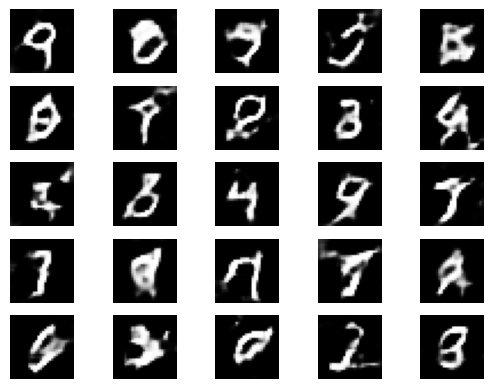

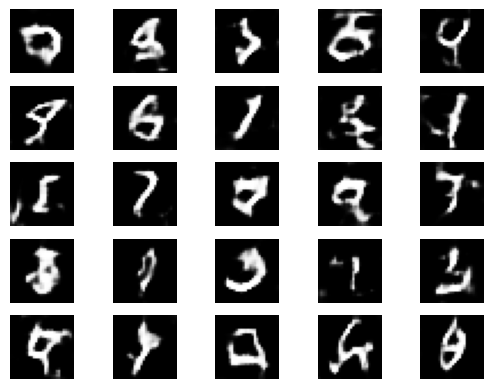

In [7]:
gan_train(2001, 32, 200)